In [1]:
import os

# Check current working directory
print("Current directory:", os.getcwd())

# Change directory
os.chdir("/lab/deasylab3/")

# Verify change
print("New directory:", os.getcwd())

import os
import numpy as np
import pandas as pd
import tiffslide
from PIL import Image
import matplotlib.pyplot as plt
data_path = '/lab/deasylab3/Jung/Data/Shared_Data/TCGA_Lung/pathology-slides/'
out_dir = "/lab/deasylab3/Himangi/psg/"

Current directory: /cluster/home/srivash/venvs/Mussel/path_gene_multimodal
New directory: /lab/deasylab3


In [2]:
image_files = os.listdir(data_path)

In [3]:
wsi_path = data_path + image_files[67]

In [4]:
classes = [
  "Tumor epithelium",
  "Tumor-associated stroma (desmoplastic stroma)",
  "Normal alveolar parenchyma",
  "Bronchial epithelium / cartilage",
  "Necrosis",
  "Hemorrhage / blood",
  "Vessel endothelium",
  "Lymphoid aggregate / TLS",
  "Adipose",
  "Background / artifact"
]


In [5]:
classes = [ "Tumor epithelium",
  "Tumor-associated stroma (desmoplastic stroma)",
 "Vessel endothelium",
  "Necrosis",
  "Lymphoid aggregate / TLS",
]

In [6]:
def show_tiff_thumbnail(tif_path, size=None):
    """
    Display a thumbnail of a TIF whole-slide image using tiffslide.
    
    Parameters:
        tif_path (str): Path to the .tif file
        size (tuple or None): (width, height) for a fixed-size thumbnail.
                              If None, smallest slide level is used.
    """
    slide = tiffslide.TiffSlide(tif_path)

    if size is None:
        # Use smallest resolution level
        level = slide.level_count - 1
        thumb = slide.read_region(
            location=(0, 0),
            level=level,
            size=slide.level_dimensions[level]
        )
    else:
        # Use tiffslide's built-in thumbnail scaler
        thumb = slide.get_thumbnail(size=size)

    plt.figure(figsize=(12, 12))
    plt.imshow(thumb)
    plt.axis("off")
    plt.show()


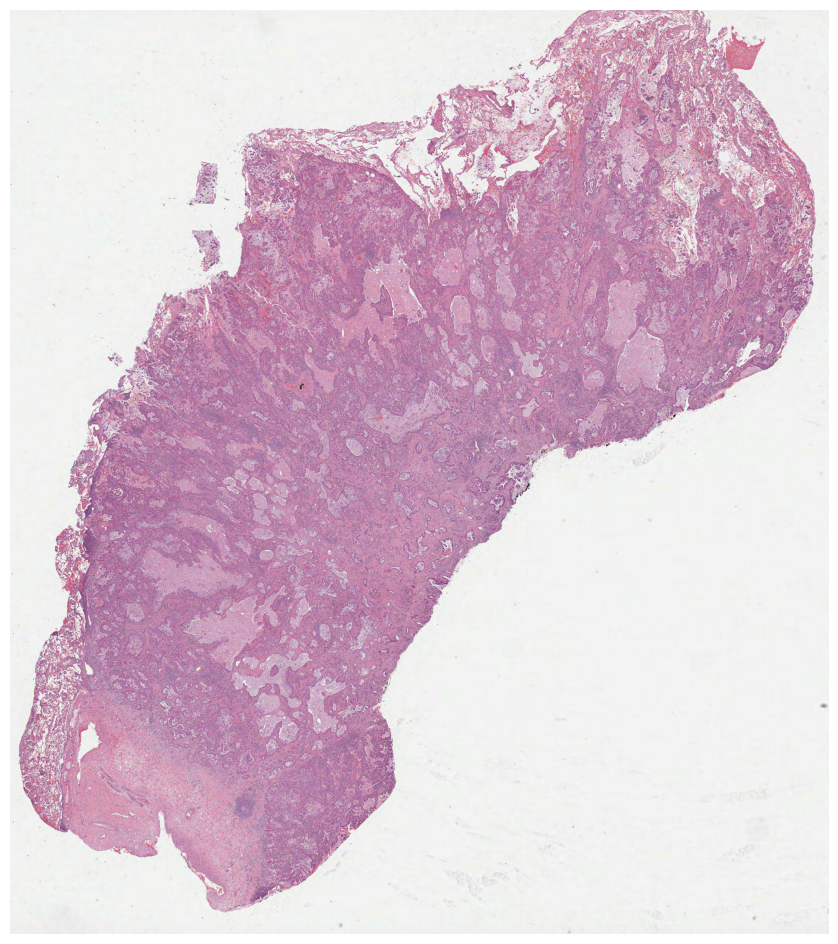

In [7]:
show_tiff_thumbnail(wsi_path)

In [8]:
import sys
sys.path.append("/cluster/home/srivash/venvs/Mussel/path_gene_multimodal")

from tiling import *
from extract_embedding_from_tiles import *
from create_embedding import *
from find_annotation_from_embedding import *
from load_annotation_with_coordinates import *
from create_and_overlay_polygon_from_prediction import*


/cluster/home/srivash/venvs/Mussel/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
run_tessellation(wsi_path,out_dir)

2025-11-25 15:03:30.096 | INFO     | mussel.utils.segment:segment_tissue:273 - slide_mpp: 0.252
2025-11-25 15:03:30.097 | DEBUG    | mussel.utils.segment:get_native_size:182 - desired_mpp: 0.500, slide_mpp: 0.252, mpp scale: 1.984
2025-11-25 15:03:30.097 | DEBUG    | mussel.utils.segment:get_native_size:182 - desired_mpp: 0.500, slide_mpp: 0.252, mpp scale: 1.984
2025-11-25 15:03:30.098 | INFO     | mussel.utils.segment:segment_tissue:277 - native_step_size: 508
2025-11-25 15:03:30.098 | INFO     | mussel.utils.segment:segment_tissue:278 - native_patch_size: 508
2025-11-25 15:03:30.536 | INFO     | mussel.utils.segment:segment_tissue:334 - Creating patches for: TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f ...
2025-11-25 15:03:30.537 | INFO     | mussel.utils.segment:segment_tissue:340 - Total number of contours: 1
2025-11-25 15:03:31.658 | INFO     | mussel.utils.segment:segment_tissue:345 - Total number of patches: 10655
2025-11-25 15:03:31.800 | INFO     | mussel.util

Tessellation complete! Results saved in /lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f


'/lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f'

In [29]:
run_extract_features_for_tessellation(
    wsi_path,
    base_output_dir=out_dir,
    model_type="CLIP",
    use_gpu=True,
    batch_size=128,
)

2025-11-25 15:14:47.013 | INFO     | mussel.cli.extract_features:main:217 - loading model checkpoint
2025-11-25 15:14:50.814 | INFO     | mussel.datasets.h5:summary:78 - hole_area_threshold 4080
2025-11-25 15:14:50.815 | INFO     | mussel.datasets.h5:summary:78 - level_dim [70984 80104]
2025-11-25 15:14:50.816 | INFO     | mussel.datasets.h5:summary:78 - max_num_holes 8
2025-11-25 15:14:50.816 | INFO     | mussel.datasets.h5:summary:78 - median_blur_ksize 7
2025-11-25 15:14:50.817 | INFO     | mussel.datasets.h5:summary:78 - morphology_ex_kernel 0
2025-11-25 15:14:50.817 | INFO     | mussel.datasets.h5:summary:78 - mpp 0.5
2025-11-25 15:14:50.819 | INFO     | mussel.datasets.h5:summary:78 - name TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f
2025-11-25 15:14:50.821 | INFO     | mussel.datasets.h5:summary:78 - native_mpp 0.252
2025-11-25 15:14:50.821 | INFO     | mussel.datasets.h5:summary:78 - patch_level 0
2025-11-25 15:14:50.822 | INFO     | mussel.datasets.h5:summary:7

[extract_features] Done → /lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f_features.h5, /lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f_features.pt


{'features_h5': '/lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f_features.h5',
 'features_pt': '/lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f_features.pt',
 'tiles_h5': '/lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f.h5',
 'outdir': '/lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f'}

In [30]:
class_pt = run_create_class_embeddings(classes, wsi_path, out_dir)

[class-embeddings] Done → /lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f_classes.pt


In [ ]:
# 4) Annotate tiles (pixel coordinates, classes in a  CSV))
csv_path = run_annotation_for_extracted_features(
    wsi_path,
    class_embedding_pt_path=class_pt,
    classes=classes,
    base_output_dir=out_dir,
)

In [9]:
df = load_annotations_with_coords(wsi_path,classes, base_output_dir=out_dir)
print("Annotations_df:", df)

Annotations_df:        tile_index  Tumor epithelium  \
0               0          0.331284   
1               1          0.326542   
2               2          0.329246   
3               3          0.315200   
4               4          0.316596   
...           ...               ...   
10650       10650          0.343794   
10651       10651          0.330378   
10652       10652          0.327850   
10653       10653          0.327245   
10654       10654          0.351738   

       Tumor-associated stroma (desmoplastic stroma)  Vessel endothelium  \
0                                           0.305813            0.387036   
1                                           0.297724            0.388812   
2                                           0.323002            0.384264   
3                                           0.316280            0.370458   
4                                           0.292402            0.373411   
...                                              ...       

In [10]:
features = build_polygons_for_all_classes(
    df, classes, tile_w=None, tile_h=None, priorities=classes,
     smooth_radius_tiles=1.0, blur_sigma=None, area_min_tiles=3, simplify_frac=0.2,
     min_polygon_area_px=3*565*565,
 )

In [11]:
export_geojson(
    features=features,
    wsi_path=wsi_path,
    base_output_dir=out_dir,
    output_pt_path=None,  # optional override
)


[✓] Saved GeoJSON (114 features) → /lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f.geojson


PosixPath('/lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f.geojson')

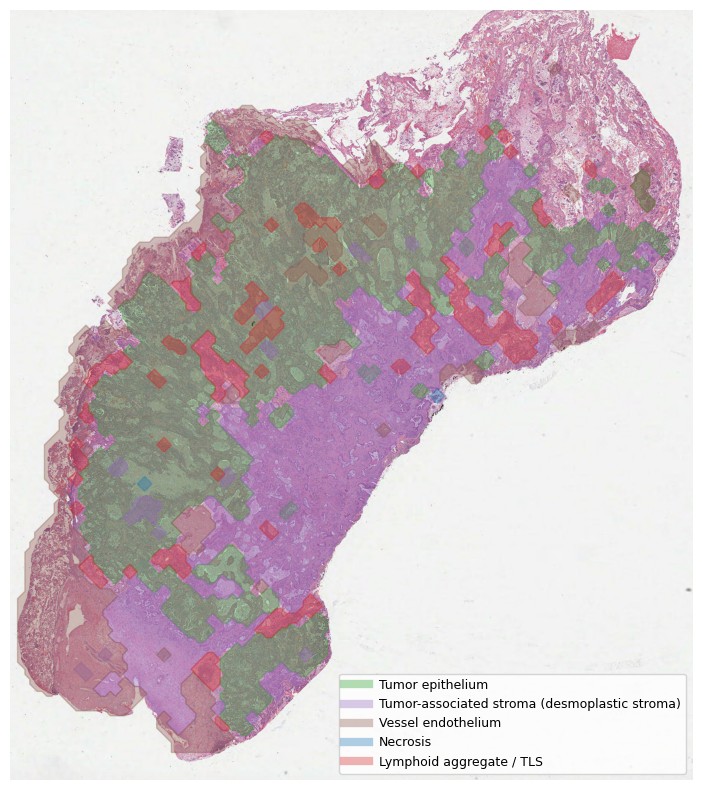

[✓] Saved all-classes overlay → /lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f_all_classes_overlay.png
[✓] Saved overlay for class 'Tumor epithelium' → /lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/Tumor epithelium.png
[✓] Saved overlay for class 'Tumor-associated stroma (desmoplastic stroma)' → /lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/Tumor-associated stroma (desmoplastic stroma).png
[✓] Saved overlay for class 'Vessel endothelium' → /lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/Vessel endothelium.png
[✓] Saved overlay for class 'Necrosis' → /lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-3eab-4b6c-9cd7-7486ffab037f/Necrosis.png
[✓] Saved overlay for class 'Lymphoid aggregate / TLS' → /lab/deasylab3/Himangi/psg/TCGA-55-6970-01Z-00-DX1.be042a9b-

In [12]:
svs_path = wsi_path
thumb, sx, sy, _ = load_svs_thumbnail(svs_path, size=(2000, 2000))  # or None

# 2) Scale geometries from level-0 pixels → thumbnail pixels
#    Your 'features' geometries are in level-0 pixel coords (from the pipeline).
features_thumb = []
for f in features:
    g_thumb = scale_geometry_to_thumb(f["geometry"], sx, sy)
    features_thumb.append({"class": f["class"], "geometry": json.loads(json.dumps(g_thumb.__geo_interface__))})


# features should already be in thumbnail coords
out_path = plot_overlays_all_classes(
    thumb,
    features_thumb,
    wsi_path=wsi_path,
    base_output_dir=out_dir,
    show=True
)

saved = plot_overlays_per_class(
    thumb,
    features_thumb,
    wsi_path=wsi_path,
    base_output_dir=out_dir
)